# Prerequisites

In [1]:
import os
import sys

sys.path.append("..")

In [10]:
import argparse
import json
import os
import random
import time

import numpy as np
import pandas as pd
import torch
import torchmetrics
from monai import losses
from monai.networks import nets
from torch import nn
from torch.optim import Adam
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

from dataset3d import get_dloader_noise
from util3d import get_obj_score3d, get_saliency3d, show_volume

In [3]:
# Random seed
seed = 191510

data_dir = "/work3/s191510/data/BugNIST_DATA"
name_legend = {
    "ac": "brown_cricket",
    "bc": "black_cricket",
    "bf": "blow_fly",
    "bl": "buffalo_bettle_larva",
    "bp": "blow_fly_pupa",
    "cf": "curly-wing_fly",
    "gh": "grasshopper",
    "ma": "maggot",
    "ml": "mealworm",
    "pp": "green_bottle_fly_pupa",
    "sl": "soldier_fly_larva",
    "wo": "woodlice",
}

model_types = {
    "r18": "ResNet 18",
}


def get_model(model_type, device="cpu", seed=191510):
    torch.manual_seed(seed)
    model = nets.UNet(
        spatial_dims=3,
        in_channels=1,
        out_channels=len(name_legend) + 1,  # Bug classes and background
        channels=(32, 64, 128, 256),
        strides=(2, 2, 2),
        num_res_units=2,
    )

    model.to(device)
    return model

# Model

In [4]:
model = get_model("")

In [6]:
# model

## Forward unit test

In [16]:
dloader = get_dloader_noise("train", 2, "../data/BugNIST_DATA")
perlin = False

if perlin:
    get_input = lambda volumes, masks, noise: volumes * masks + ~masks * noise
else:
    get_input = lambda volumes, masks, noise: volumes * masks

In [17]:
volumes, labels, masks, noise = next(iter(dloader))

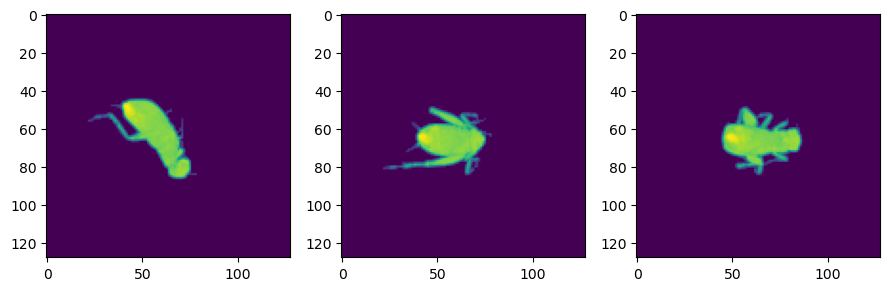

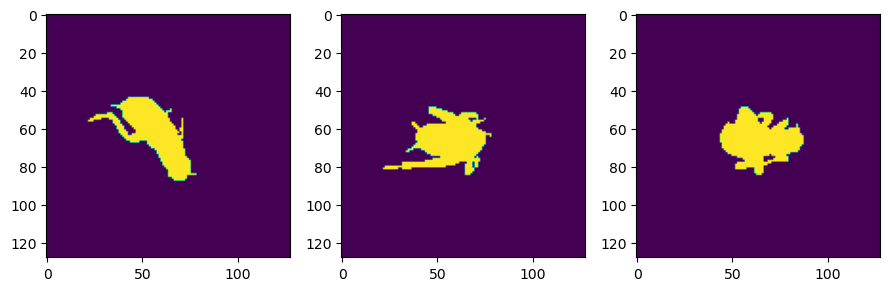

In [24]:
show_volume(get_input(volumes, masks, noise)[0], size=3)
show_volume(masks[0], size=3)

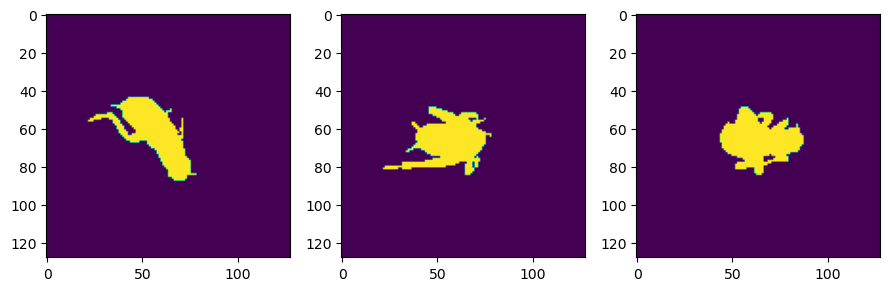

In [34]:
target = (labels.view(-1, 1, 1, 1, 1) + 1) * masks  # Background = 0
show_volume(target[0], size=3)

In [42]:
out = model(get_input(volumes, masks, noise))

In [44]:
out.size()

torch.Size([2, 13, 128, 128, 128])

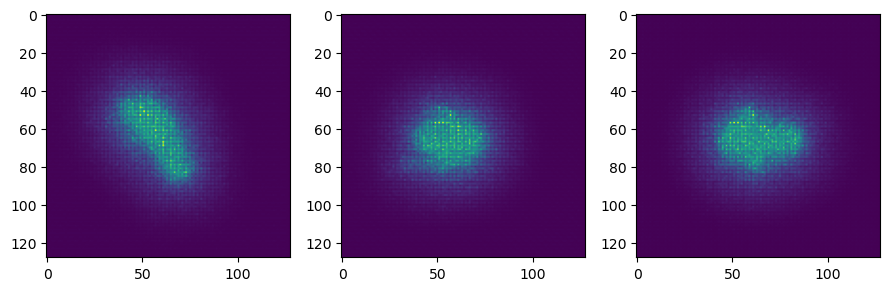

In [52]:
show_volume(out[0].detach().max(0)[0], size=3)

## Loss

In [53]:
criterion = losses.DiceCELoss(to_onehot_y=True, softmax=True, include_background=True)

In [56]:
loss = criterion(out, target)
loss.item()

3.792086601257324

In [59]:
pred = torch.softmax(out.detach(), dim=1)

In [61]:
pred.size()

torch.Size([2, 13, 128, 128, 128])

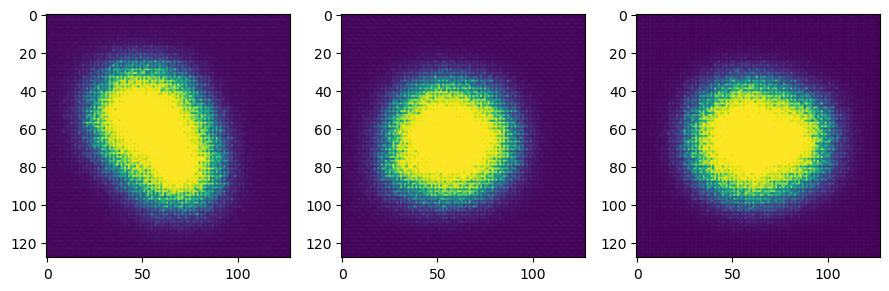

In [65]:
show_volume(pred[0].max(0)[0], size=3)

In [74]:
pred[0][:, 0, 0, 0].sum()

tensor(1.)

In [86]:
(out.cpu().detach().max(1)[1].flatten(1) == target.flatten(1)).float().mean(1)

tensor([0.0122, 0.0118])

In [85]:
out.cpu().detach().max(1)[1]

tensor([[[[11,  1,  9,  ...,  2,  9,  9],
          [ 1,  5,  1,  ...,  6,  1,  5],
          [ 9,  1, 11,  ...,  1,  9,  9],
          ...,
          [ 1, 12,  1,  ..., 12,  1,  8],
          [ 9,  2,  9,  ...,  1,  9,  9],
          [ 1,  6,  1,  ..., 11,  1, 11]],

         [[ 1,  3,  1,  ..., 11,  1, 11],
          [ 9,  5,  9,  ...,  4,  9,  1],
          [ 8,  3,  8,  ...,  4,  9,  9],
          ...,
          [ 9,  4,  9,  ..., 12,  9,  1],
          [ 1,  1,  8,  ...,  1,  1,  1],
          [ 9,  9,  9,  ..., 12,  9,  1]],

         [[ 9,  1,  1,  ...,  1,  1,  1],
          [11, 12,  1,  ..., 12,  1, 12],
          [ 9,  1,  9,  ...,  9,  9,  1],
          ...,
          [11,  2,  5,  ..., 12,  1, 11],
          [ 9,  9,  9,  ...,  2,  9,  9],
          [ 1, 11, 11,  ..., 11, 11,  1]],

         ...,

         [[ 8,  3,  1,  ..., 11,  1,  1],
          [ 9,  9,  9,  ...,  9,  9,  1],
          [ 8, 11,  8,  ..., 11,  1,  9],
          ...,
          [ 9, 12,  9,  ...,  9,  9, 